In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import os
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.core.HyperbandOptimiser import HyperbandOptimiser
from autotune.core.RandomOptimiser import RandomOptimiser
from autotune.core.TpeOptimiser import TpeOptimiser

In [14]:
def plot_convergence(optimisers, problem_text=""):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
    lines = ['--bs', '--kd', '--ro']
    for i, optimiser in enumerate(optimisers):
        ax.plot(optimiser.checkpoints, optimiser.Y_best, lines[i], label=optimiser.name)
    
    ax.set_ylim(0.15,0.32)
    ax.grid()
    plt.ylabel('Min Test Error')
    plt.xlabel('Time (s)')
    plt.legend()
    
    res = ["{} min error = {}".format(opt.name, min(opt.Y)) for opt in optimisers]
    title = problem_text + "\n" + "\n".join(res)
    plt.title(title)
    plt.savefig(path+"/"+problem_text, dpi=200)
    plt.show()

In [24]:
problem_text = "cifar_9hps_3"
#problem_text = "tpe_test"
path = '/Users/signapoop/Desktop/results/' + problem_text
os.chdir(path)
file = open("results.pkl",'rb')
object_file = pickle.load(file)
file.close()

# Unpack file
hyper_opt = object_file[0]
random_opt = object_file[1]

In [25]:
file = open("tpe_only_results.pkl",'rb')
object_file_2 = pickle.load(file)
file.close()
tpe_opt = object_file_2[0]
object_file.append(tpe_opt)

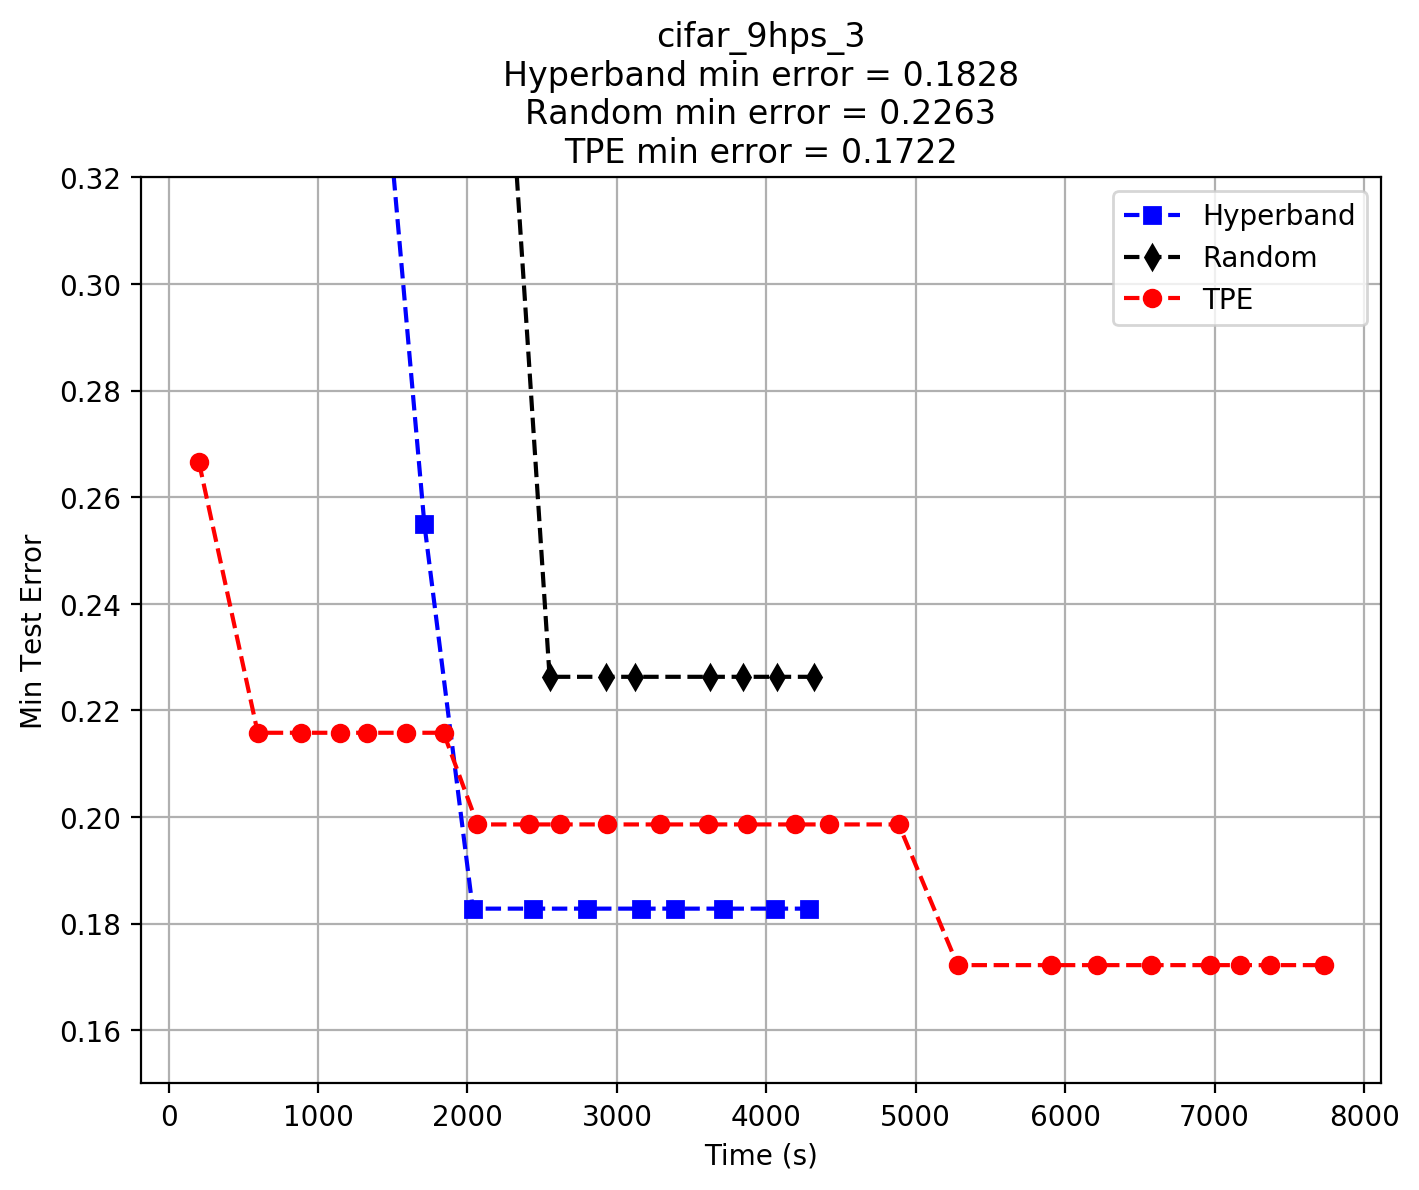

In [26]:
# Plot convergence
plot_convergence(object_file, problem_text)

## Parallel Coordinates

In [15]:
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.benchmarks.mnist_problem import MnistProblem
from autotune.benchmarks.cifar_problem_2 import CifarProblem2
input_dir = '/Users/signapoop/Desktop/data/'
output_dir = '/Users/signapoop/Desktop/autotune/autotune/experiments/checkpoint/'
problem = CifarProblem2(input_dir, output_dir)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using GPUs? : False


In [16]:
hps = problem.domain.keys()
arms = {}
for hp in hps:
    arms[hp] = [arm[hp] for arm in hyper_opt.arms]
print(hps)

['lr_step', 'gamma', 'momentum', 'n_units_2', 'n_units_3', 'n_units_1', 'learning_rate', 'weight_decay', 'batch_size']


In [17]:
if 'n_resources' in hps:
    hps.remove('n_resources')

In [18]:
ranges = {}
for hp in hps:
    ranges[hp] = [problem.domain[hp].get_min(), problem.domain[hp].get_max()]
print(ranges)

{'n_units_2': [4, 8], 'n_units_3': [4, 8], 'n_units_1': [4, 8], 'learning_rate': [-6, 0], 'batch_size': [32, 512], 'lr_step': [1, 5], 'gamma': [-3, -1], 'weight_decay': [-6, -1], 'momentum': [0.3, 0.999]}


In [19]:
# Handle params on log scale
labels = {}
for hp in hps:
    labels[hp] = hp
    if problem.domain[hp].scale == 'log':
        arms[hp] = np.log(arms[hp]) / np.log(problem.domain[hp].logbase)
        labels[hp] = labels[hp] + '_log'

In [20]:
# Plot parallel coordinates with plotly
import plotly.plotly as py
import plotly.graph_objs as go

data = [
    go.Parcoords(
        line = dict(color = hyper_opt.Y,
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 1),
        dimensions = [
            dict(range = ranges[hp],
                 label = labels[hp], values = arms[hp]) for hp in hps
        ]
    )
]

py.iplot(data, filename = 'parcoords-advanced', image='png', width=250)

## Cifar_new

In [9]:
problem_text = "cifar_new"
path = '/Users/signapoop/Desktop/results/' + problem_text
os.chdir(path)
file = open("results.pkl",'rb')
object_file = pickle.load(file)
file.close()

# Unpack file
hyper_opt = object_file[0]

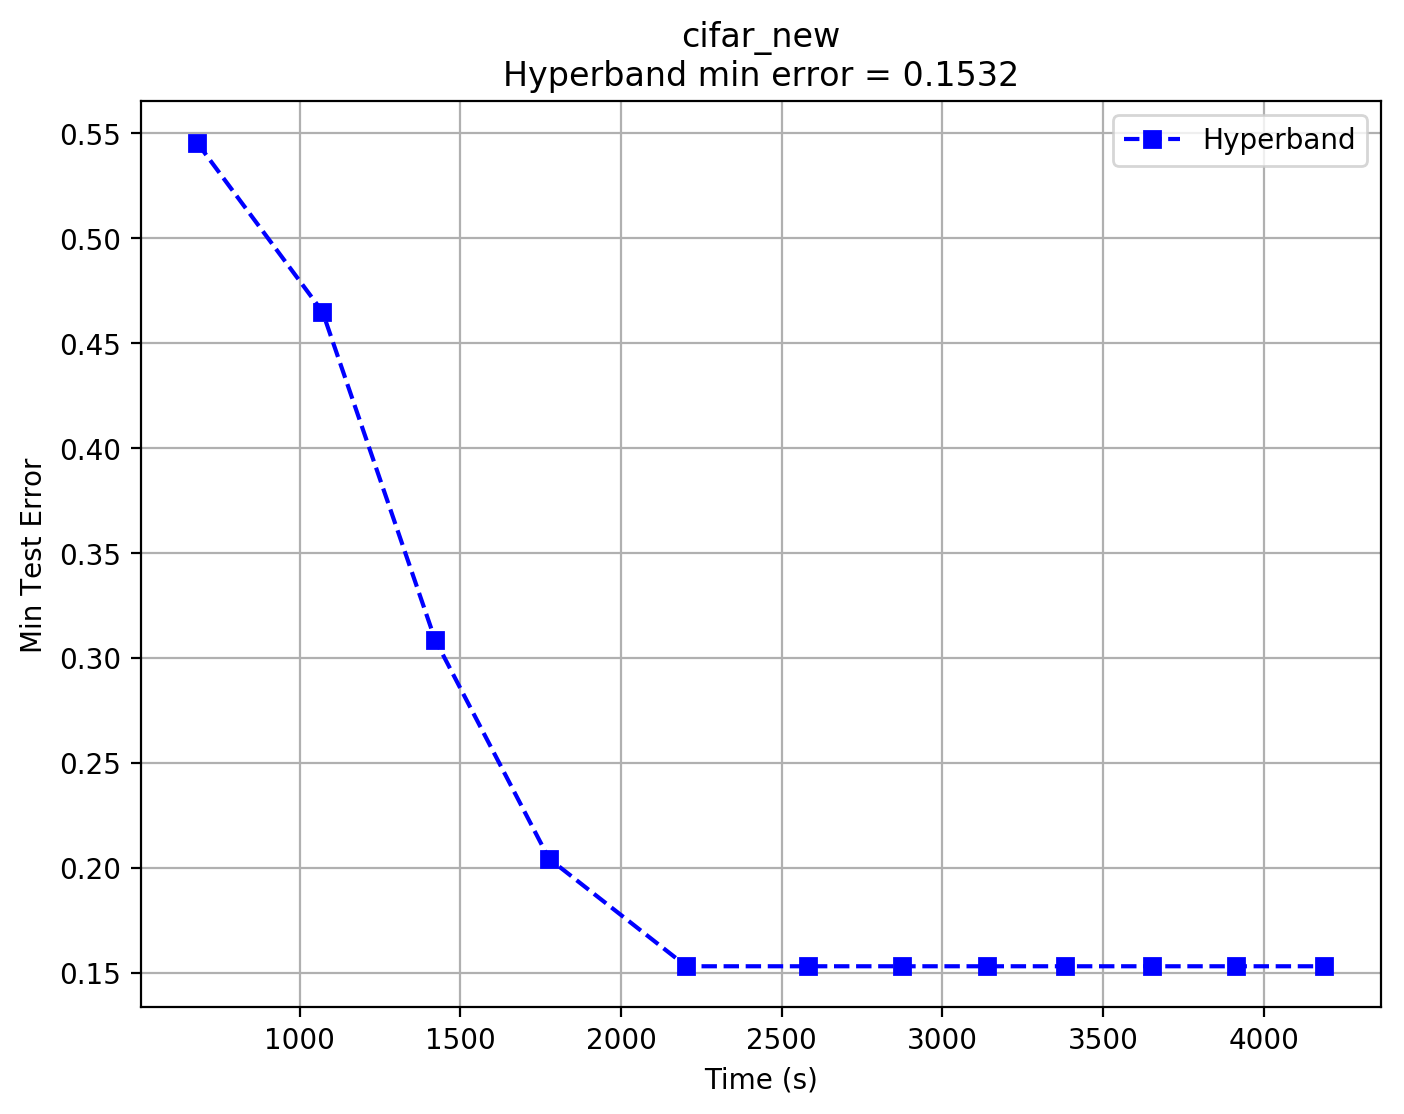

In [10]:
plot_convergence([hyper_opt], problem_text)